Quantum Communication Sender and Receiver Simulation Report

Introduction

The simulation represents a basic quantum communication sender and receiver system, utilizing the polarization of single photons as qubits. The objective is to encode, transmit, receive, and measure quantum states while accounting for noise and implementing error correction mechanisms.

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import *
from ibm_quantum_widgets import *
from numpy import pi
from qiskit_aer import Aer
from qiskit import transpile
import random

#A function for generating a random sequense
def generate_random_sequence(length):
    return [random.randint(0, 1) for _ in range(length)]


In [ ]:
#The length of the sequence
length=5
random_sequence = generate_random_sequence(length)
print(random_sequence)


[1, 0, 0, 0, 1]


1. Encoding and Decoding Functions

These functions handle the preparation of qubits for transmission and their decoding upon reception.

    Encoding Function:
        Purpose: Encodes a single qubit into the Shor algorithm set of qubits.
        Functionality: Applies operations for phase and bit flips to encode the qubit.

    Decoding Function:
        Purpose: Decodes the received qubits back to the single-qubit state.
        Functionality: Reverses the operations performed during encoding.

2. Error Correction

Error correction mechanisms are essential to ensure the accuracy and reliability of transmitted quantum information.

    Bit Parity Check Function:
        Purpose: Checks for parity errors in the bit-flip encoding.
        Functionality: Applies CNOT gates to check the parity between qubits.

    Bit Correction Block Function:
        Purpose: Corrects errors identified by the bit parity check.
        Functionality: Applies conditional operations to correct errors based on the parity syndrome.

    Bit Error Correction Function:
        Purpose: Implements error correction using the Shor code.
        Functionality: Utilizes the bit parity check and correction block functions for error correction.

3. Phase Correction

Phase correction mechanisms ensure the integrity of the phase-flip encoding.

    Phase Parity Check Function:
        Purpose: Checks for parity errors in the phase-flip encoding.
        Functionality: Stores the data, checks parity, and restores the encoded form.

    Phase Correction Block Function:
        Purpose: Corrects errors identified by the phase parity check.
        Functionality: Applies conditional operations to correct errors based on the parity syndrome.

    Phase Error Correction Function:
        Purpose: Implements error correction for phase-flip errors.
        Functionality: Utilizes the phase parity check and correction block functions for error correction.

4. Noise Model

The noise model introduces errors into the quantum states, mimicking real-world noise sources.

    Bit Noise Function:
        Purpose: Introduces partial bit flip noise to the qubits.
        Functionality: Applies rotation gates to induce bit flip errors.

    Phase Noise Function:
        Purpose: Introduces partial phase flip noise to the qubits.
        Functionality: Applies rotation gates to induce phase flip errors.

In [ ]:
#defining all the ShorCodes function
#This function uses one Logical qubit to encode 8 other qubits so that we can use it for bit and phase flip encoding
def Encoding(cir):
    # Phase- flip
    cir.cx(8,5)
    cir.cx(8,2)
    cir.h(2)
    cir.h(5)
    cir.h(8)
    #Bit-flip
    cir.cx(8,6)
    cir.cx(8,7)
    cir.cx(5,3)
    cir.cx(5,4)
    cir.cx(2,0)
    cir.cx(2,1)
    return cir
#This function Decodes the qubits so it can be used again
def Decoding(cir):
    #Bit-flip
    cir.cx(8,6)
    cir.cx(8,7)
    cir.cx(5,3)
    cir.cx(5,4)
    cir.cx(2,0)
    cir.cx(2,1)
    #Phase-flip
    cir.h(2)
    cir.h(5)
    cir.h(8)
    cir.cx(8,5)
    cir.cx(8,2)
    return cir
#Its time for bit flip for that we use a parity check function
def BitParityCheck(cir,SQubit,AuxQubit):
    cir.cx(SQubit,AuxQubit)
    cir.cx(SQubit+1,AuxQubit)
    cir.cx(SQubit+1,AuxQubit+1)
    cir.cx(SQubit+2,AuxQubit+1)
    return cir
#And We need a CorrectionBlock
def BitCorrectionBlock(cir,SQubit,AuxQubit):
    cir.x(AuxQubit)
    cir.ccx(AuxQubit+1,AuxQubit,SQubit+2)
    cir.x(AuxQubit)
    cir.ccx(AuxQubit+1,AuxQubit,SQubit+1)
    cir.x(AuxQubit+1)
    cir.ccx(AuxQubit+1,AuxQubit,SQubit)
    cir.x(AuxQubit+1)
    cir.measure(AuxQubit,AuxQubit)
    cir.measure(AuxQubit+1,AuxQubit+1)
    cir.reset(AuxQubit)
    cir.reset(AuxQubit+1)
    return cir
#Now bringing it all toghether we construct the Error Correction function
def BitErrorCorrection(cir,AuxQubit):
    for i in range(3):
        cir = BitParityCheck(cir,i*3,AuxQubit)
        cir.barrier()
        cir = BitCorrectionBlock(cir,i*3,AuxQubit)
    return cir
def PhaseParityCheck(cir,AuxQubit):
    #Storing the data in Q8,5,2
    cir.cx(8,6)
    cir.cx(8,7)
    cir.cx(5,3)
    cir.cx(5,4)
    cir.cx(2,0)
    cir.cx(2,1)
    cir.h(2)
    cir.h(5)
    cir.h(8)
    #Getting the parity stored in the Aux Qubits
    cir.cx(2,AuxQubit)
    cir.cx(5,AuxQubit)
    cir.cx(5,AuxQubit+1)
    cir.cx(8,AuxQubit+1)
    #restoring the Encoded Form
    cir.h(2)
    cir.h(5)
    cir.h(8)
    cir.cx(8,6)
    cir.cx(8,7)
    cir.cx(5,3)
    cir.cx(5,4)
    cir.cx(2,0)
    cir.cx(2,1)
    return cir
def PhaseCorrectionBlock(cir,AuxQubit):
    cir.x(AuxQubit)
    cir.ccz(AuxQubit+1,AuxQubit,8)
    cir.x(AuxQubit)
    cir.ccz(AuxQubit+1,AuxQubit,5)
    cir.x(AuxQubit+1)
    cir.ccz(AuxQubit+1,AuxQubit,2)
    cir.x(AuxQubit+1)
    cir.measure(AuxQubit,AuxQubit)
    cir.measure(AuxQubit+1,AuxQubit+1)
    cir.reset(AuxQubit)
    cir.reset(AuxQubit+1)
    return cir
def PhaseErrorCorrection(cir,AuxQubit):
    cir = PhaseParityCheck(cir,AuxQubit)
    cir.barrier()
    cir = PhaseCorrectionBlock(cir,AuxQubit)
    return cir
def BitNoise(cir,TarQubit,theta):
    cir.rx(theta,TarQubit)
    return cir
def PhaseNoise(cir,TarQubit,theta):
    cir.rz(theta,TarQubit)
    return cir


5. Sending and Receiving Photons

The primary functions for sending and receiving single photons and measuring their states.

    Send Single Photon Function:
        Purpose: Encodes, introduces noise, and sends a single photon.
        Functionality: Executes encoding, noise application, error correction, and decoding operations.

    Measure Single Photon Function:
        Purpose: Measures the state of the received qubits.
        Functionality: Utilizes a quantum simulator to measure the qubits' states and returns the measurement outcomes.

In [ ]:
#A function that encodes The single qubit into a shor algorithm set of qubits and sends and meausere it on the otherside
def SendSinglePhoton(cir):
    cir = Encoding(cir)
    cir = BitNoise(cir,8,0.9273)
    cir.barrier()
    cir = BitErrorCorrection(cir,9)
    cir.barrier()
    cir = Decoding(cir)
    cir.barrier()
    cir.measure([0,1,2,3,4,5,6,7,8,9,10],[0,1,2,3,4,5,6,7,8,9,10])
    return cir
def MeasureSinglePhoton(cir):
    # Use Aer's qasm_simulator
    simulator = Aer.get_backend('qasm_simulator')
    # Execute the circuit on the qasm simulator
    new_circuit = transpile(cir, simulator)
    job = simulator.run(new_circuit)
    # Grab results from the job
    result = job.result()
    # Return counts
    counts = result.get_counts(cir)
    return counts
def SinglePhoton(sequence,length):
    ListOfCounts = []
    for i in range(length):
        circuit = QuantumCircuit(11,11)
        if sequence[i] == 1:
            #encoding one bit into the 8th qubit of the shor circuit
            circuit.x(8)
        circuit = SendSinglePhoton(circuit)
        counts = MeasureSinglePhoton(circuit)
        ListOfCounts.append(counts)
        del circuit
    return ListOfCounts


6. Simulation Execution

The simulation is executed by sending single photons based on a randomly generated bit sequence.

    Single Photon Function:
        Purpose: Simulates the transmission and reception of single photons.
        Functionality: Iteratively sends single photons based on the input sequence and records measurement outcomes.

In [ ]:
List = SinglePhoton(random_sequence,length)

In [ ]:
print(List)

[{'00100000000': 1024}, {'00000000000': 1024}, {'00000000000': 1024}, {'00000000000': 1024}, {'00100000000': 1024}]


In [ ]:
result_list = []

for item in List:
    for key, value in item.items():
        third_bit = key[2]  # Extract the 3rd bit of the key
        result_list.append({third_bit: value})

print(result_list)

[{'1': 1024}, {'0': 1024}, {'0': 1024}, {'0': 1024}, {'1': 1024}]


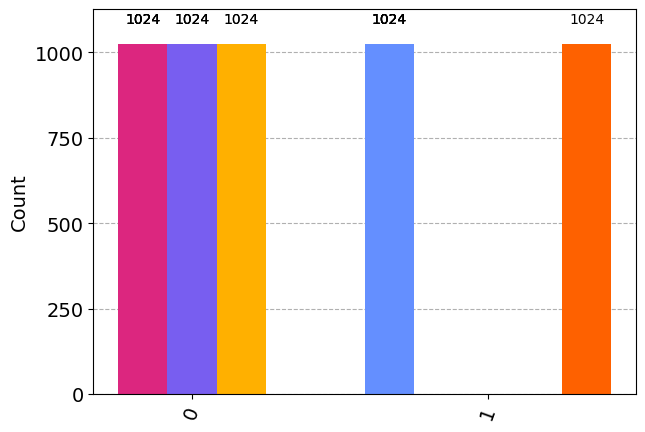

In [ ]:
plot_histogram(result_list)